In [1]:
import zipfile, os

zip_path = "/content/Dataset.zip"
extract_dir = "/content/Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(os.listdir(extract_dir))

['Dataset']


1. Setup & Imports

In [2]:
import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import (
    accuracy_score, f1_score, cohen_kappa_score, roc_auc_score,
    average_precision_score, mean_squared_error
)

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2. Global Parameters & Labels

In [3]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 8

EXPRESSION_LABELS = {
    0: "Neutral", 1: "Happy", 2: "Sad", 3: "Surprise",
    4: "Fear", 5: "Disgust", 6: "Anger", 7: "Contempt"
}

ANNOTATIONS_DIR = '/content/Dataset/Dataset/annotations'
IMAGES_DIR = '/content/Dataset/Dataset/images'


3. Load & Preprocess Annotations

In [4]:
def load_and_preprocess_annotations(directory_path):
    annotations_data = {}
    if not os.path.exists(directory_path):
        print(f"Error: The specified annotation directory does not exist: '{directory_path}'")
        return {}

    files_in_dir = os.listdir(directory_path)

    for filename in files_in_dir:
        if filename.endswith('_lnd.npy'):
            prefix = filename.replace('_lnd.npy', '')

            try:
                annotations_data[prefix] = {
                    'landmarks_id': np.load(os.path.join(directory_path, f'{prefix}_lnd.npy')),
                    'arousal': np.load(os.path.join(directory_path, f'{prefix}_aro.npy')),
                    'expression': np.load(os.path.join(directory_path, f'{prefix}_exp.npy')),
                    'valence': np.load(os.path.join(directory_path, f'{prefix}_val.npy'))
                }
            except Exception as e:
                print(f"Error loading {prefix}: {e}")
    return annotations_data

all_annotations = load_and_preprocess_annotations(ANNOTATIONS_DIR)
print(f"Loaded annotations for {len(all_annotations)} samples")


Loaded annotations for 3999 samples


4. Pair Images with Annotations

In [5]:
image_paths, expressions, valences, arousals = [], [], [], []

for prefix, data in all_annotations.items():
    img_path = os.path.join(IMAGES_DIR, f'{prefix}.jpg')
    if not os.path.exists(img_path):
        img_path = os.path.join(IMAGES_DIR, f'{prefix}.png')
        if not os.path.exists(img_path):
            continue

    expressions.append(int(data['expression'].flatten()[0]))
    valences.append(float(data['valence'].flatten()[0]))
    arousals.append(float(data['arousal'].flatten()[0]))
    image_paths.append(img_path)

image_paths = np.array(image_paths)
expressions = np.array(expressions)
valences = np.array(valences)
arousals = np.array(arousals)

lb = LabelBinarizer()
expressions_one_hot = lb.fit_transform(expressions)

print(f"Final paired dataset: {len(image_paths)} samples")


Final paired dataset: 3999 samples


5. Train/Validation Split

In [6]:
X_train_paths, X_val_paths, y_exp_train, y_exp_val, y_val_train, y_val_val, y_aro_train, y_aro_val = \
    train_test_split(image_paths, expressions_one_hot, valences, arousals,
                     test_size=0.2, random_state=42, stratify=expressions)

print(f"Train: {len(X_train_paths)}, Validation: {len(X_val_paths)}")


Train: 3199, Validation: 800


6. Custom Data Generator

In [7]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, expressions, valences, arousals,
                 batch_size, img_height, img_width, augment=False):
        self.image_paths = image_paths
        self.expressions = expressions
        self.valences = valences
        self.arousals = arousals
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.augment = augment
        self.on_epoch_end()

        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                shear_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                fill_mode='nearest'
            )

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_paths))
        np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X = np.empty((self.batch_size, self.img_height, self.img_width, 3), dtype=np.float32)

        batch_paths = [self.image_paths[k] for k in indexes]
        batch_exp = self.expressions[indexes]
        batch_val = self.valences[indexes]
        batch_aro = self.arousals[indexes]

        for i, path in enumerate(batch_paths):
            img = cv2.imread(path)
            if img is None:
                img = np.zeros((self.img_height, self.img_width, 3), dtype=np.uint8)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (self.img_width, self.img_height))
            img = img.astype(np.float32) / 255.0
            if self.augment:
                img = self.datagen.random_transform(img)
            X[i,] = img

        return X, {'expression_output': batch_exp,
                   'valence_output': batch_val,
                   'arousal_output': batch_aro}

train_generator = CustomDataGenerator(
    X_train_paths, y_exp_train, y_val_train, y_aro_train,
    BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, augment=True
)
val_generator = CustomDataGenerator(
    X_val_paths, y_exp_val, y_val_val, y_aro_val,
    BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, augment=False
)


7. Baseline Models (ResNet50 / VGG16)

In [8]:
def create_multi_output_model(base_model_name, input_shape, num_classes):
    if base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unsupported base model")

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    exp_out = Dense(num_classes, activation='softmax', name='expression_output')(x)
    val_out = Dense(1, activation='linear', name='valence_output')(x)
    aro_out = Dense(1, activation='linear', name='arousal_output')(x)

    return Model(inputs=base_model.input, outputs=[exp_out, val_out, aro_out])

8. Custom CNN Architecture


In [9]:
def create_custom_cnn(input_shape=(224,224,3), num_classes=8):
    model = Sequential()

    model.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2)))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    exp_out = Dense(num_classes, activation='softmax', name='expression_output')(model.output)
    val_out = Dense(1, activation='linear', name='valence_output')(model.output)
    aro_out = Dense(1, activation='linear', name='arousal_output')(model.output)

    return Model(inputs=model.input, outputs=[exp_out, val_out, aro_out])


9. Compile, Train & Evaluate (All Models)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def create_custom_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Conv2D(256, (3,3), activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.4)(x)  # regularization
    shared = layers.Dense(128, activation="relu")(x)


    expression_output = layers.Dense(num_classes, activation="softmax", name="expression_output")(shared)
    valence_output = layers.Dense(1, activation="linear", name="valence_output")(shared)
    arousal_output = layers.Dense(1, activation="linear", name="arousal_output")(shared)

    model = models.Model(inputs=inputs, outputs=[expression_output, valence_output, arousal_output], name="CustomCNN")
    return model

def compile_and_train(model, name, train_gen, val_gen, epochs=20):
    model.compile(
        optimizer=optimizers.Adam(1e-3),
        loss={
            'expression_output': 'categorical_crossentropy',
            'valence_output': 'mse',
            'arousal_output': 'mse'
        },
        metrics={
            'expression_output': ['accuracy'],
            'valence_output': ['mae'],
            'arousal_output': ['mae']
        }
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint(f"{name}.h5", save_best_only=True, monitor='val_loss')
    ]

    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, callbacks=callbacks)
    return history


resnet_model = create_multi_output_model("ResNet50", (224,224,3), NUM_CLASSES)
vgg_model = create_multi_output_model("VGG16", (224,224,3), NUM_CLASSES)
custom_model = create_custom_cnn((224,224,3), NUM_CLASSES)

history_resnet = compile_and_train(resnet_model, "resnet50_fer_va", train_generator, val_generator, EPOCHS)
history_vgg = compile_and_train(vgg_model, "vgg16_fer_va", train_generator, val_generator, EPOCHS)
history_custom = compile_and_train(custom_model, "customcnn_fer_va", train_generator, val_generator, EPOCHS)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - arousal_output_loss: 0.6059 - arousal_output_mae: 0.5791 - expression_output_accuracy: 0.1245 - expression_output_loss: 2.2108 - loss: 3.3206 - valence_output_loss: 0.5039 - valence_output_mae: 0.5437

99/99 ━━━━━━━━━━━━━━━━━━━━ 59s 449ms/step - arousal_output_loss: 0.6028 - arousal_output_mae: 0.5775 - expression_output_accuracy: 0.1245 - expression_output_loss: 2.2100 - loss: 3.3148 - valence_output_loss: 0.5020 - valence_output_mae: 0.5426 - val_arousal_output_loss: 0.1518 - val_arousal_output_mae: 0.3444 - val_expression_output_accuracy: 0.1250 - val_expression_output_loss: 2.0803 - val_loss: 2.4534 - val_valence_output_loss: 0.2212 - val_valence_output_mae: 0.3852
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 68s 385ms/step - arousal_output_loss: 0.1558 - arousal_output_mae: 0.3412 - expression_output_accuracy: 0.1207 - expression_output_loss: 2.0854 - loss: 2.4636 - valence_output_loss: 0.2224 - valence_output_mae: 0.3860 - val_arousal_output_loss: 0.1480 - val_arousal_output_mae: 0.3330 - val_expression_output_accuracy: 0.1262 - val_expression_output_loss: 2.0825 - val_loss: 2.4551 - val_valence_output_loss: 0.2246 - val_valence_output_mae: 0.3877
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 39s 394ms/step - arousal_output_loss: 0.1575 - arousal_output_mae: 0.3447 - expression_output_accuracy: 0.1200 - expression_output_loss: 2.0837 - loss: 2.4625 - valence_output_loss: 0.2214 - valence_output_mae: 0.3852 - val_arousal_output_loss: 0.1478 - val_arousal_output_mae: 0.3332 - val_expression_output_accuracy: 0.1250 - val_expression_output_loss: 2.0812 - val_loss: 2.4514 - val_valence_output_loss: 0.2224 - val_valence_output_mae: 0.3862
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - arousal_output_loss: 0.1545 - arousal_output_mae: 0.3394 - expression_output_accuracy: 0.1169 - expression_output_loss: 2.0844 - loss: 2.4584 - valence_output_loss: 0.2196 - valence_output_mae: 0.3851

99/99 ━━━━━━━━━━━━━━━━━━━━ 39s 393ms/step - arousal_output_loss: 0.1545 - arousal_output_mae: 0.3394 - expression_output_accuracy: 0.1169 - expression_output_loss: 2.0844 - loss: 2.4584 - valence_output_loss: 0.2196 - valence_output_mae: 0.3851 - val_arousal_output_loss: 0.1483 - val_arousal_output_mae: 0.3363 - val_expression_output_accuracy: 0.1250 - val_expression_output_loss: 2.0797 - val_loss: 2.4489 - val_valence_output_loss: 0.2210 - val_valence_output_mae: 0.3854
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 387ms/step - arousal_output_loss: 0.1564 - arousal_output_mae: 0.3421 - expression_output_accuracy: 0.1314 - expression_output_loss: 2.0802 - loss: 2.4594 - valence_output_loss: 0.2228 - valence_output_mae: 0.3873 - val_arousal_output_loss: 0.1572 - val_arousal_output_mae: 0.3525 - val_expression_output_accuracy: 0.1325 - val_expression_output_loss: 2.0793 - val_loss: 2.4603 - val_valence_output_loss: 0.2238 - val_valence_output_mae: 0.3872
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 48s 490ms/step - arousal_output_loss: 0.1473 - arousal_output_mae: 0.3339 - expression_output_accuracy: 0.1225 - expression_output_loss: 2.0804 - loss: 2.4449 - valence_output_loss: 0.2172 - valence_output_mae: 0.3814 - val_arousal_output_loss: 0.1490 - val_arousal_output_mae: 0.3383 - val_expression_output_accuracy: 0.1300 - val_expression_output_loss: 2.0791 - val_loss: 2.4489 - val_valence_output_loss: 0.2207 - val_valence_output_mae: 0.3850
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - arousal_output_loss: 0.1484 - arousal_output_mae: 0.3358 - expression_output_accuracy: 0.1156 - expression_output_loss: 2.0793 - loss: 2.4525 - valence_output_loss: 0.2248 - valence_output_mae: 0.3864

99/99 ━━━━━━━━━━━━━━━━━━━━ 39s 394ms/step - arousal_output_loss: 0.1484 - arousal_output_mae: 0.3358 - expression_output_accuracy: 0.1156 - expression_output_loss: 2.0793 - loss: 2.4524 - valence_output_loss: 0.2247 - valence_output_mae: 0.3864 - val_arousal_output_loss: 0.1488 - val_arousal_output_mae: 0.3373 - val_expression_output_accuracy: 0.1287 - val_expression_output_loss: 2.0793 - val_loss: 2.4488 - val_valence_output_loss: 0.2207 - val_valence_output_mae: 0.3849
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - arousal_output_loss: 0.1488 - arousal_output_mae: 0.3395 - expression_output_accuracy: 0.1325 - expression_output_loss: 2.0798 - loss: 2.4584 - valence_output_loss: 0.2297 - valence_output_mae: 0.3930

99/99 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step - arousal_output_loss: 0.1488 - arousal_output_mae: 0.3395 - expression_output_accuracy: 0.1324 - expression_output_loss: 2.0798 - loss: 2.4582 - valence_output_loss: 0.2296 - valence_output_mae: 0.3929 - val_arousal_output_loss: 0.1485 - val_arousal_output_mae: 0.3364 - val_expression_output_accuracy: 0.1312 - val_expression_output_loss: 2.0790 - val_loss: 2.4483 - val_valence_output_loss: 0.2208 - val_valence_output_mae: 0.3851
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - arousal_output_loss: 0.1452 - arousal_output_mae: 0.3337 - expression_output_accuracy: 0.1249 - expression_output_loss: 2.0797 - loss: 2.4405 - valence_output_loss: 0.2157 - valence_output_mae: 0.3796

99/99 ━━━━━━━━━━━━━━━━━━━━ 40s 402ms/step - arousal_output_loss: 0.1452 - arousal_output_mae: 0.3337 - expression_output_accuracy: 0.1248 - expression_output_loss: 2.0797 - loss: 2.4405 - valence_output_loss: 0.2157 - valence_output_mae: 0.3796 - val_arousal_output_loss: 0.1481 - val_arousal_output_mae: 0.3342 - val_expression_output_accuracy: 0.1262 - val_expression_output_loss: 2.0789 - val_loss: 2.4479 - val_valence_output_loss: 0.2209 - val_valence_output_mae: 0.3851
Epoch 13/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 39s 390ms/step - arousal_output_loss: 0.1412 - arousal_output_mae: 0.3283 - expression_output_accuracy: 0.1239 - expression_output_loss: 2.0798 - loss: 2.4371 - valence_output_loss: 0.2161 - valence_output_mae: 0.3810 - val_arousal_output_loss: 0.1484 - val_arousal_output_mae: 0.3341 - val_expression_output_accuracy: 0.1262 - val_expression_output_loss: 2.0792 - val_loss: 2.4485 - val_valence_output_loss: 0.2209 - val_valence_output_mae: 0.3850
Epoch 14/20
99/99 ━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 398ms/step - arousal_output_loss: 0.1423 - arousal_output_mae: 0.3266 - expression_output_accuracy: 0.1324 - expression_output_loss: 2.0787 - loss: 2.4327 - valence_output_loss: 0.2117 - valence_output_mae: 0.3784 - val_arousal_output_loss: 0.1483 - val_arousal_output_mae: 0.3321 - val_expression_output_accuracy: 0.1250 - val_expression_output_loss: 2.0785 - val_loss: 2.4477 - val_valence_output_loss: 0.2208 - val_valence_output_mae: 0.3850
Epoch 17/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 385ms/step - arousal_output_loss: 0.1418 - arousal_output_mae: 0.3268 - expression_output_accuracy: 0.1183 - expression_output_loss: 2.0790 - loss: 2.4423 - valence_output_loss: 0.2215 - valence_output_mae: 0.3875 - val_arousal_output_loss: 0.1486 - val_arousal_output_mae: 0.3345 - val_expression_output_accuracy: 0.1400 - val_expression_output_loss: 2.0786 - val_loss: 2.4480 - val_valence_output_loss: 0.2209 - val_valence_output_mae: 0.3849
Epoch 18/20
99/99 ━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 39s 397ms/step - arousal_output_loss: 0.1389 - arousal_output_mae: 0.3235 - expression_output_accuracy: 0.1371 - expression_output_loss: 2.0784 - loss: 2.4365 - valence_output_loss: 0.2191 - valence_output_mae: 0.3858 - val_arousal_output_loss: 0.1481 - val_arousal_output_mae: 0.3315 - val_expression_output_accuracy: 0.1500 - val_expression_output_loss: 2.0778 - val_loss: 2.4467 - val_valence_output_loss: 0.2208 - val_valence_output_mae: 0.3849
Epoch 19/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 40s 406ms/step - arousal_output_loss: 0.1451 - arousal_output_mae: 0.3299 - expression_output_accuracy: 0.1169 - expression_output_loss: 2.0783 - loss: 2.4468 - valence_output_loss: 0.2234 - valence_output_mae: 0.3888 - val_arousal_output_loss: 0.1483 - val_arousal_output_mae: 0.3338 - val_expression_output_accuracy: 0.1538 - val_expression_output_loss: 2.0777 - val_loss: 2.4468 - val_valence_output_loss: 0.2209 - val_valence_output_mae: 0.3849
Epoch 20/20
99/99 ━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 59s 439ms/step - arousal_output_loss: 0.2919 - arousal_output_mae: 0.4327 - expression_output_accuracy: 0.1292 - expression_output_loss: 2.1514 - loss: 2.7916 - valence_output_loss: 0.3483 - valence_output_mae: 0.4707 - val_arousal_output_loss: 0.1408 - val_arousal_output_mae: 0.3303 - val_expression_output_accuracy: 0.2013 - val_expression_output_loss: 2.0427 - val_loss: 2.3889 - val_valence_output_loss: 0.2055 - val_valence_output_mae: 0.3705
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - arousal_output_loss: 0.1457 - arousal_output_mae: 0.3252 - expression_output_accuracy: 0.1711 - expression_output_loss: 2.0449 - loss: 2.4010 - valence_output_loss: 0.2104 - valence_output_mae: 0.3735

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 432ms/step - arousal_output_loss: 0.1457 - arousal_output_mae: 0.3252 - expression_output_accuracy: 0.1713 - expression_output_loss: 2.0447 - loss: 2.4008 - valence_output_loss: 0.2104 - valence_output_mae: 0.3735 - val_arousal_output_loss: 0.1399 - val_arousal_output_mae: 0.3106 - val_expression_output_accuracy: 0.2300 - val_expression_output_loss: 1.9946 - val_loss: 2.3346 - val_valence_output_loss: 0.2002 - val_valence_output_mae: 0.3666
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - arousal_output_loss: 0.1408 - arousal_output_mae: 0.3165 - expression_output_accuracy: 0.2133 - expression_output_loss: 1.9985 - loss: 2.3473 - valence_output_loss: 0.2080 - valence_output_mae: 0.3718

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 438ms/step - arousal_output_loss: 0.1409 - arousal_output_mae: 0.3166 - expression_output_accuracy: 0.2134 - expression_output_loss: 1.9985 - loss: 2.3473 - valence_output_loss: 0.2080 - valence_output_mae: 0.3719 - val_arousal_output_loss: 0.1361 - val_arousal_output_mae: 0.3186 - val_expression_output_accuracy: 0.2463 - val_expression_output_loss: 1.9561 - val_loss: 2.2939 - val_valence_output_loss: 0.2017 - val_valence_output_mae: 0.3695
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - arousal_output_loss: 0.1447 - arousal_output_mae: 0.3262 - expression_output_accuracy: 0.2430 - expression_output_loss: 1.9669 - loss: 2.3123 - valence_output_loss: 0.2007 - valence_output_mae: 0.3640

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - arousal_output_loss: 0.1447 - arousal_output_mae: 0.3262 - expression_output_accuracy: 0.2430 - expression_output_loss: 1.9669 - loss: 2.3124 - valence_output_loss: 0.2008 - valence_output_mae: 0.3641 - val_arousal_output_loss: 0.1357 - val_arousal_output_mae: 0.3141 - val_expression_output_accuracy: 0.2375 - val_expression_output_loss: 1.9279 - val_loss: 2.2779 - val_valence_output_loss: 0.2142 - val_valence_output_mae: 0.3832
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - arousal_output_loss: 0.1423 - arousal_output_mae: 0.3208 - expression_output_accuracy: 0.2486 - expression_output_loss: 1.9329 - loss: 2.2840 - valence_output_loss: 0.2088 - valence_output_mae: 0.3746

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 433ms/step - arousal_output_loss: 0.1423 - arousal_output_mae: 0.3208 - expression_output_accuracy: 0.2485 - expression_output_loss: 1.9330 - loss: 2.2840 - valence_output_loss: 0.2088 - valence_output_mae: 0.3746 - val_arousal_output_loss: 0.1402 - val_arousal_output_mae: 0.3098 - val_expression_output_accuracy: 0.2525 - val_expression_output_loss: 1.8992 - val_loss: 2.2374 - val_valence_output_loss: 0.1980 - val_valence_output_mae: 0.3667
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - arousal_output_loss: 0.1394 - arousal_output_mae: 0.3177 - expression_output_accuracy: 0.2564 - expression_output_loss: 1.9080 - loss: 2.2563 - valence_output_loss: 0.2089 - valence_output_mae: 0.3763

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 431ms/step - arousal_output_loss: 0.1394 - arousal_output_mae: 0.3177 - expression_output_accuracy: 0.2562 - expression_output_loss: 1.9081 - loss: 2.2564 - valence_output_loss: 0.2089 - valence_output_mae: 0.3763 - val_arousal_output_loss: 0.1355 - val_arousal_output_mae: 0.3169 - val_expression_output_accuracy: 0.2362 - val_expression_output_loss: 1.8830 - val_loss: 2.2169 - val_valence_output_loss: 0.1984 - val_valence_output_mae: 0.3660
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - arousal_output_loss: 0.1345 - arousal_output_mae: 0.3140 - expression_output_accuracy: 0.2532 - expression_output_loss: 1.8958 - loss: 2.2315 - valence_output_loss: 0.2011 - valence_output_mae: 0.3665

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 439ms/step - arousal_output_loss: 0.1345 - arousal_output_mae: 0.3140 - expression_output_accuracy: 0.2533 - expression_output_loss: 1.8958 - loss: 2.2315 - valence_output_loss: 0.2011 - valence_output_mae: 0.3665 - val_arousal_output_loss: 0.1340 - val_arousal_output_mae: 0.3111 - val_expression_output_accuracy: 0.2637 - val_expression_output_loss: 1.8584 - val_loss: 2.1882 - val_valence_output_loss: 0.1958 - val_valence_output_mae: 0.3637
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - arousal_output_loss: 0.1351 - arousal_output_mae: 0.3140 - expression_output_accuracy: 0.2616 - expression_output_loss: 1.9019 - loss: 2.2464 - valence_output_loss: 0.2094 - valence_output_mae: 0.3777

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - arousal_output_loss: 0.1352 - arousal_output_mae: 0.3140 - expression_output_accuracy: 0.2616 - expression_output_loss: 1.9018 - loss: 2.2462 - valence_output_loss: 0.2093 - valence_output_mae: 0.3776 - val_arousal_output_loss: 0.1350 - val_arousal_output_mae: 0.3129 - val_expression_output_accuracy: 0.2725 - val_expression_output_loss: 1.8537 - val_loss: 2.1858 - val_valence_output_loss: 0.1970 - val_valence_output_mae: 0.3650
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - arousal_output_loss: 0.1385 - arousal_output_mae: 0.3219 - expression_output_accuracy: 0.2555 - expression_output_loss: 1.8851 - loss: 2.2179 - valence_output_loss: 0.1942 - valence_output_mae: 0.3613

99/99 ━━━━━━━━━━━━━━━━━━━━ 44s 441ms/step - arousal_output_loss: 0.1385 - arousal_output_mae: 0.3219 - expression_output_accuracy: 0.2556 - expression_output_loss: 1.8850 - loss: 2.2178 - valence_output_loss: 0.1943 - valence_output_mae: 0.3613 - val_arousal_output_loss: 0.1365 - val_arousal_output_mae: 0.3218 - val_expression_output_accuracy: 0.2725 - val_expression_output_loss: 1.8398 - val_loss: 2.1698 - val_valence_output_loss: 0.1935 - val_valence_output_mae: 0.3625
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - arousal_output_loss: 0.1384 - arousal_output_mae: 0.3167 - expression_output_accuracy: 0.2803 - expression_output_loss: 1.8762 - loss: 2.2095 - valence_output_loss: 0.1949 - valence_output_mae: 0.3592

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 429ms/step - arousal_output_loss: 0.1384 - arousal_output_mae: 0.3167 - expression_output_accuracy: 0.2803 - expression_output_loss: 1.8761 - loss: 2.2093 - valence_output_loss: 0.1949 - valence_output_mae: 0.3592 - val_arousal_output_loss: 0.1339 - val_arousal_output_mae: 0.3130 - val_expression_output_accuracy: 0.2812 - val_expression_output_loss: 1.8368 - val_loss: 2.1619 - val_valence_output_loss: 0.1912 - val_valence_output_mae: 0.3582
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - arousal_output_loss: 0.1358 - arousal_output_mae: 0.3130 - expression_output_accuracy: 0.3025 - expression_output_loss: 1.8410 - loss: 2.1852 - valence_output_loss: 0.2083 - valence_output_mae: 0.3760

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 435ms/step - arousal_output_loss: 0.1358 - arousal_output_mae: 0.3130 - expression_output_accuracy: 0.3023 - expression_output_loss: 1.8411 - loss: 2.1852 - valence_output_loss: 0.2082 - valence_output_mae: 0.3758 - val_arousal_output_loss: 0.1346 - val_arousal_output_mae: 0.3148 - val_expression_output_accuracy: 0.2750 - val_expression_output_loss: 1.8307 - val_loss: 2.1562 - val_valence_output_loss: 0.1909 - val_valence_output_mae: 0.3578
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - arousal_output_loss: 0.1332 - arousal_output_mae: 0.3110 - expression_output_accuracy: 0.2782 - expression_output_loss: 1.8603 - loss: 2.1905 - valence_output_loss: 0.1970 - valence_output_mae: 0.3623

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 432ms/step - arousal_output_loss: 0.1332 - arousal_output_mae: 0.3110 - expression_output_accuracy: 0.2783 - expression_output_loss: 1.8601 - loss: 2.1904 - valence_output_loss: 0.1970 - valence_output_mae: 0.3623 - val_arousal_output_loss: 0.1339 - val_arousal_output_mae: 0.3119 - val_expression_output_accuracy: 0.2850 - val_expression_output_loss: 1.8139 - val_loss: 2.1408 - val_valence_output_loss: 0.1931 - val_valence_output_mae: 0.3603
Epoch 13/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 426ms/step - arousal_output_loss: 0.1353 - arousal_output_mae: 0.3134 - expression_output_accuracy: 0.2909 - expression_output_loss: 1.8397 - loss: 2.1646 - valence_output_loss: 0.1896 - valence_output_mae: 0.3538 - val_arousal_output_loss: 0.1353 - val_arousal_output_mae: 0.3205 - val_expression_output_accuracy: 0.2887 - val_expression_output_loss: 1.8181 - val_loss: 2.1433 - val_valence_output_loss: 0.1900 - val_valence_output_mae: 0.3591
Epoch 14/20
99/99 ━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 436ms/step - arousal_output_loss: 0.1371 - arousal_output_mae: 0.3159 - expression_output_accuracy: 0.2791 - expression_output_loss: 1.8480 - loss: 2.1797 - valence_output_loss: 0.1946 - valence_output_mae: 0.3590 - val_arousal_output_loss: 0.1346 - val_arousal_output_mae: 0.3146 - val_expression_output_accuracy: 0.2937 - val_expression_output_loss: 1.8005 - val_loss: 2.1229 - val_valence_output_loss: 0.1878 - val_valence_output_mae: 0.3548
Epoch 15/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 429ms/step - arousal_output_loss: 0.1310 - arousal_output_mae: 0.3093 - expression_output_accuracy: 0.2774 - expression_output_loss: 1.8188 - loss: 2.1404 - valence_output_loss: 0.1906 - valence_output_mae: 0.3559 - val_arousal_output_loss: 0.1365 - val_arousal_output_mae: 0.3228 - val_expression_output_accuracy: 0.2725 - val_expression_output_loss: 1.8275 - val_loss: 2.1612 - val_valence_output_loss: 0.1971 - val_valence_output_mae: 0.3579
Epoch 16/20
99/99 ━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 432ms/step - arousal_output_loss: 0.1334 - arousal_output_mae: 0.3109 - expression_output_accuracy: 0.2842 - expression_output_loss: 1.8385 - loss: 2.1614 - valence_output_loss: 0.1894 - valence_output_mae: 0.3537 - val_arousal_output_loss: 0.1342 - val_arousal_output_mae: 0.3149 - val_expression_output_accuracy: 0.2962 - val_expression_output_loss: 1.7959 - val_loss: 2.1172 - val_valence_output_loss: 0.1872 - val_valence_output_mae: 0.3558
Epoch 17/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 42s 426ms/step - arousal_output_loss: 0.1400 - arousal_output_mae: 0.3198 - expression_output_accuracy: 0.3076 - expression_output_loss: 1.8109 - loss: 2.1334 - valence_output_loss: 0.1826 - valence_output_mae: 0.3494 - val_arousal_output_loss: 0.1399 - val_arousal_output_mae: 0.3298 - val_expression_output_accuracy: 0.2962 - val_expression_output_loss: 1.7966 - val_loss: 2.1224 - val_valence_output_loss: 0.1859 - val_valence_output_mae: 0.3555
Epoch 18/20
99/99 ━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 430ms/step - arousal_output_loss: 0.1329 - arousal_output_mae: 0.3137 - expression_output_accuracy: 0.2930 - expression_output_loss: 1.8155 - loss: 2.1336 - valence_output_loss: 0.1853 - valence_output_mae: 0.3529 - val_arousal_output_loss: 0.1339 - val_arousal_output_mae: 0.3103 - val_expression_output_accuracy: 0.2937 - val_expression_output_loss: 1.7914 - val_loss: 2.1126 - val_valence_output_loss: 0.1873 - val_valence_output_mae: 0.3567
Epoch 19/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 429ms/step - arousal_output_loss: 0.1345 - arousal_output_mae: 0.3108 - expression_output_accuracy: 0.2954 - expression_output_loss: 1.8153 - loss: 2.1339 - valence_output_loss: 0.1841 - valence_output_mae: 0.3479 - val_arousal_output_loss: 0.1365 - val_arousal_output_mae: 0.3227 - val_expression_output_accuracy: 0.2962 - val_expression_output_loss: 1.7956 - val_loss: 2.1145 - val_valence_output_loss: 0.1824 - val_valence_output_mae: 0.3506
Epoch 20/20
99/99 ━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 43s 439ms/step - arousal_output_loss: 0.1333 - arousal_output_mae: 0.3094 - expression_output_accuracy: 0.3199 - expression_output_loss: 1.7544 - loss: 2.0774 - valence_output_loss: 0.1898 - valence_output_mae: 0.3562 - val_arousal_output_loss: 0.1345 - val_arousal_output_mae: 0.3146 - val_expression_output_accuracy: 0.3175 - val_expression_output_loss: 1.7881 - val_loss: 2.1097 - val_valence_output_loss: 0.1871 - val_valence_output_mae: 0.3525
Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - arousal_output_loss: 0.3270 - arousal_output_mae: 0.4517 - expression_output_accuracy: 0.1333 - expression_output_loss: 2.1952 - loss: 2.9725 - valence_output_loss: 0.4502 - valence_output_mae: 0.5420

99/99 ━━━━━━━━━━━━━━━━━━━━ 50s 385ms/step - arousal_output_loss: 0.3263 - arousal_output_mae: 0.4512 - expression_output_accuracy: 0.1333 - expression_output_loss: 2.1948 - loss: 2.9704 - valence_output_loss: 0.4493 - valence_output_mae: 0.5414 - val_arousal_output_loss: 0.2136 - val_arousal_output_mae: 0.3519 - val_expression_output_accuracy: 0.1250 - val_expression_output_loss: 2.1277 - val_loss: 2.6118 - val_valence_output_loss: 0.2705 - val_valence_output_mae: 0.4084
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 365ms/step - arousal_output_loss: 0.1735 - arousal_output_mae: 0.3514 - expression_output_accuracy: 0.1458 - expression_output_loss: 2.0955 - loss: 2.5105 - valence_output_loss: 0.2414 - valence_output_mae: 0.3981 - val_arousal_output_loss: 0.1595 - val_arousal_output_mae: 0.3246 - val_expression_output_accuracy: 0.1250 - val_expression_output_loss: 2.3941 - val_loss: 2.8560 - val_valence_output_loss: 0.3025 - val_valence_output_mae: 0.4278
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 370ms/step - arousal_output_loss: 0.1548 - arousal_output_mae: 0.3350 - expression_output_accuracy: 0.1683 - expression_output_loss: 2.0662 - loss: 2.4550 - valence_output_loss: 0.2341 - valence_output_mae: 0.3941 - val_arousal_output_loss: 0.1486 - val_arousal_output_mae: 0.3320 - val_expression_output_accuracy: 0.1488 - val_expression_output_loss: 2.1443 - val_loss: 2.5127 - val_valence_output_loss: 0.2198 - val_valence_output_mae: 0.3822
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - arousal_output_loss: 0.1539 - arousal_output_mae: 0.3373 - expression_output_accuracy: 0.1714 - expression_output_loss: 2.0605 - loss: 2.4399 - valence_output_loss: 0.2255 - valence_output_mae: 0.3890

99/99 ━━━━━━━━━━━━━━━━━━━━ 38s 385ms/step - arousal_output_loss: 0.1538 - arousal_output_mae: 0.3373 - expression_output_accuracy: 0.1714 - expression_output_loss: 2.0605 - loss: 2.4398 - valence_output_loss: 0.2255 - valence_output_mae: 0.3890 - val_arousal_output_loss: 0.1530 - val_arousal_output_mae: 0.3391 - val_expression_output_accuracy: 0.1775 - val_expression_output_loss: 2.0772 - val_loss: 2.4485 - val_valence_output_loss: 0.2183 - val_valence_output_mae: 0.3829
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 366ms/step - arousal_output_loss: 0.1443 - arousal_output_mae: 0.3241 - expression_output_accuracy: 0.1721 - expression_output_loss: 2.0476 - loss: 2.4152 - valence_output_loss: 0.2233 - valence_output_mae: 0.3859 - val_arousal_output_loss: 0.1502 - val_arousal_output_mae: 0.3310 - val_expression_output_accuracy: 0.1650 - val_expression_output_loss: 2.0737 - val_loss: 2.4523 - val_valence_output_loss: 0.2284 - val_valence_output_mae: 0.3873
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 369ms/step - arousal_output_loss: 0.1489 - arousal_output_mae: 0.3323 - expression_output_accuracy: 0.1689 - expression_output_loss: 2.0397 - loss: 2.4136 - valence_output_loss: 0.2251 - valence_output_mae: 0.3915 - val_arousal_output_loss: 0.1526 - val_arousal_output_mae: 0.3367 - val_expression_output_accuracy: 0.1887 - val_expression_output_loss: 2.0392 - val_loss: 2.4162 - val_valence_output_loss: 0.2244 - val_valence_output_mae: 0.3882
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 370ms/step - arousal_output_loss: 0.1462 - arousal_output_mae: 0.3271 - expression_output_accuracy: 0.1851 - expression_output_loss: 2.0420 - loss: 2.4044 - valence_output_loss: 0.2162 - valence_output_mae: 0.3804 - val_arousal_output_loss: 0.1555 - val_arousal_output_mae: 0.3287 - val_expression_output_accuracy: 0.1462 - val_expression_output_loss: 2.1394 - val_loss: 2.5341 - val_valence_output_loss: 0.2392 - val_valence_output_mae: 0.3958
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 366ms/step - arousal_output_loss: 0.1448 - arousal_output_mae: 0.3254 - expression_output_accuracy: 0.1989 - expression_output_loss: 2.0265 - loss: 2.3852 - valence_output_loss: 0.2140 - valence_output_mae: 0.3773 - val_arousal_output_loss: 0.1513 - val_arousal_output_mae: 0.3404 - val_expression_output_accuracy: 0.1713 - val_expression_output_loss: 2.0338 - val_loss: 2.4034 - val_valence_output_loss: 0.2183 - val_valence_output_mae: 0.3839
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - arousal_output_loss: 0.1482 - arousal_output_mae: 0.3306 - expression_output_accuracy: 0.1874 - expression_output_loss: 2.0339 - loss: 2.3891 - valence_output_loss: 0.2070 - valence_output_mae: 0.3699 - val_arousal_output_loss: 0.1507 - val_arousal_output_mae: 0.3350 - val_expression_output_accuracy: 0.1700 - val_expression_output_loss: 2.0432 - val_loss: 2.4129 - val_valence_output_loss: 0.2189 - val_valence_output_mae: 0.3840
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 377ms/step - arousal_output_loss: 0.1516 - arousal_output_mae: 0.3344 - expression_output_accuracy: 0.1948 - expression_output_loss: 2.0237 - loss: 2.3897 - valence_output_loss: 0.2143 - valence_output_mae: 0.3797 - val_arousal_output_loss: 0.1462 - val_arousal_output_mae: 0.3254 - val_expression_output_accuracy: 0.1963 - val_expression_output_loss: 2.0334 - val_loss: 2.4001 - val_valence_output_loss: 0.2205 - val_valence_output_mae: 0.3866
Epoch 13/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 370ms/step - arousal_output_loss: 0.1443 - arousal_output_mae: 0.3276 - expression_output_accuracy: 0.1995 - expression_output_loss: 2.0217 - loss: 2.3811 - valence_output_loss: 0.2151 - valence_output_mae: 0.3752 - val_arousal_output_loss: 0.1502 - val_arousal_output_mae: 0.3294 - val_expression_output_accuracy: 0.1725 - val_expression_output_loss: 2.0461 - val_loss: 2.4154 - val_valence_output_loss: 0.2190 - val_valence_output_mae: 0.3884
Epoch 14/20
99/99 ━━━━━━━━━━━━━━━━━━

99/99 ━━━━━━━━━━━━━━━━━━━━ 36s 368ms/step - arousal_output_loss: 0.1426 - arousal_output_mae: 0.3237 - expression_output_accuracy: 0.2063 - expression_output_loss: 1.9993 - loss: 2.3510 - valence_output_loss: 0.2091 - valence_output_mae: 0.3758 - val_arousal_output_loss: 0.1469 - val_arousal_output_mae: 0.3350 - val_expression_output_accuracy: 0.1963 - val_expression_output_loss: 2.0191 - val_loss: 2.3810 - val_valence_output_loss: 0.2150 - val_valence_output_mae: 0.3829
Epoch 17/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 37s 371ms/step - arousal_output_loss: 0.1411 - arousal_output_mae: 0.3230 - expression_output_accuracy: 0.2034 - expression_output_loss: 1.9937 - loss: 2.3427 - valence_output_loss: 0.2079 - valence_output_mae: 0.3701 - val_arousal_output_loss: 0.1600 - val_arousal_output_mae: 0.3485 - val_expression_output_accuracy: 0.1650 - val_expression_output_loss: 2.1475 - val_loss: 2.5462 - val_valence_output_loss: 0.2387 - val_valence_output_mae: 0.3902
Epoch 18/20
99/99 ━━━━━━━━━━━━━━━━━━

10. Metrics

In [11]:
!pip install krippendorff

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, f1_score, cohen_kappa_score,
    roc_auc_score, average_precision_score, mean_squared_error
)
from scipy.stats import pearsonr

try:
    import krippendorff
    HAS_KRIPP = True
except ImportError:
    HAS_KRIPP = False


def evaluate_extra_metrics(model, val_gen):
    y_true_exp, y_pred_exp = [], []
    y_true_val, y_pred_val = [], []
    y_true_aro, y_pred_aro = [], []

    for i in range(len(val_gen)):
        X_batch, y_batch = val_gen[i]
        preds = model.predict(X_batch, verbose=0)

        exp_pred = np.argmax(preds[0], axis=1)
        exp_true = np.argmax(y_batch['expression_output'], axis=1)
        y_pred_exp.extend(exp_pred)
        y_true_exp.extend(exp_true)

        y_pred_val.extend(preds[1].flatten())
        y_true_val.extend(y_batch['valence_output'])

        y_pred_aro.extend(preds[2].flatten())
        y_true_aro.extend(y_batch['arousal_output'])

    y_true_exp, y_pred_exp = np.array(y_true_exp), np.array(y_pred_exp)
    y_true_val, y_pred_val = np.array(y_true_val), np.array(y_pred_val)
    y_true_aro, y_pred_aro = np.array(y_true_aro), np.array(y_pred_aro)

    acc = accuracy_score(y_true_exp, y_pred_exp)
    f1 = f1_score(y_true_exp, y_pred_exp, average="macro")
    kappa = cohen_kappa_score(y_true_exp, y_pred_exp)

    if HAS_KRIPP:
        alpha = krippendorff.alpha(reliability_data=[y_true_exp, y_pred_exp])
    else:
        alpha = np.nan

    y_true_exp_oh = pd.get_dummies(y_true_exp)
    y_pred_exp_oh = pd.get_dummies(y_pred_exp)

    auc = roc_auc_score(y_true_exp_oh, y_pred_exp_oh, multi_class="ovr")

    try:
        auc_pr = average_precision_score(y_true_exp_oh, y_pred_exp_oh, average="macro")
    except Exception:
        auc_pr = np.nan

    classification_metrics = pd.DataFrame([
        ["Accuracy", acc, "Proportion of correctly predicted labels"],
        ["F1-Score", f1, "Harmonic mean of precision and recall"],
        ["Cohen's Kappa", kappa, "Agreement beyond chance"],
        ["Krippendorff's Alpha", alpha, "Statistical measure of agreement"],
        ["AUC", auc, "Area under ROC curve (multi-class OVR)"],
        ["AUC-PR", auc_pr, "Macro average precision across classes"]
    ], columns=["Name", "Metric", "Description"])

    def compute_continuous_metrics(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        corr, _ = pearsonr(y_true, y_pred)
        sagr = np.mean(np.sign(y_true) == np.sign(y_pred))
        mean_true, mean_pred = np.mean(y_true), np.mean(y_pred)
        var_true, var_pred = np.var(y_true), np.var(y_pred)
        ccc = (2 * corr * np.sqrt(var_true) * np.sqrt(var_pred)) / (
            var_true + var_pred + (mean_true - mean_pred) ** 2
        )
        return rmse, corr, sagr, ccc

    val_rmse, val_corr, val_sagr, val_ccc = compute_continuous_metrics(y_true_val, y_pred_val)
    aro_rmse, aro_corr, aro_sagr, aro_ccc = compute_continuous_metrics(y_true_aro, y_pred_aro)

    regression_metrics = pd.DataFrame([
        ["Valence RMSE", val_rmse, "Root Mean Square Error"],
        ["Valence CORR", val_corr, "Correlation"],
        ["Valence SAGR", val_sagr, "Sign Agreement Metric"],
        ["Valence CCC", val_ccc, "Concordance Correlation Coefficient"],
        ["Arousal RMSE", aro_rmse, "Root Mean Square Error"],
        ["Arousal CORR", aro_corr, "Correlation"],
        ["Arousal SAGR", aro_sagr, "Sign Agreement Metric"],
        ["Arousal CCC", aro_ccc, "Concordance Correlation Coefficient"],
    ], columns=["Name", "Metric", "Description"])

    return classification_metrics, regression_metrics


from IPython.display import display

print("\nMetrics for ResNet50")
resnet_class, resnet_reg = evaluate_extra_metrics(resnet_model, val_generator)
display(resnet_class)
display(resnet_reg)

print("\nMetrics for VGG16")
vgg_class, vgg_reg = evaluate_extra_metrics(vgg_model, val_generator)
display(vgg_class)
display(vgg_reg)

print("\nMetrics for Custom CNN")
custom_class, custom_reg = evaluate_extra_metrics(custom_model, val_generator)
display(custom_class)
display(custom_reg)


Metrics for ResNet50


,Name,Metric,Description
0,Accuracy,0.150000,Proportion of correctly predicted labels
1,F1-Score,0.078259,Harmonic mean of precision and recall
2,Cohen's Kappa,0.028571,Agreement beyond chance
3,Krippendorff's Alpha,-0.022353,Statistical measure of agreement
4,AUC,0.519048,Area under ROC curve (multi-class OVR)
5,AUC-PR,0.129924,Macro average precision across classes


,Name,Metric,Description
0,Valence RMSE,0.469908,Root Mean Square Error
1,Valence CORR,0.009580,Correlation
2,Valence SAGR,0.695000,Sign Agreement Metric
3,Valence CCC,0.000032,Concordance Correlation Coefficient
4,Arousal RMSE,0.384817,Root Mean Square Error
5,Arousal CORR,0.106831,Correlation
6,Arousal SAGR,0.760000,Sign Agreement Metric
7,Arousal CCC,0.005780,Concordance Correlation Coefficient



Metrics for VGG16


,Name,Metric,Description
0,Accuracy,0.317500,Proportion of correctly predicted labels
1,F1-Score,0.311036,Harmonic mean of precision and recall
2,Cohen's Kappa,0.220000,Agreement beyond chance
3,Krippendorff's Alpha,0.142153,Statistical measure of agreement
4,AUC,0.610000,Area under ROC curve (multi-class OVR)
5,AUC-PR,0.194051,Macro average precision across classes


,Name,Metric,Description
0,Valence RMSE,0.432524,Root Mean Square Error
1,Valence CORR,0.419950,Correlation
2,Valence SAGR,0.721250,Sign Agreement Metric
3,Valence CCC,0.254999,Concordance Correlation Coefficient
4,Arousal RMSE,0.366678,Root Mean Square Error
5,Arousal CORR,0.323734,Correlation
6,Arousal SAGR,0.760000,Sign Agreement Metric
7,Arousal CCC,0.143800,Concordance Correlation Coefficient



Metrics for Custom CNN


,Name,Metric,Description
0,Accuracy,0.196250,Proportion of correctly predicted labels
1,F1-Score,0.167918,Harmonic mean of precision and recall
2,Cohen's Kappa,0.081429,Agreement beyond chance
3,Krippendorff's Alpha,-0.004575,Statistical measure of agreement
4,AUC,0.540714,Area under ROC curve (multi-class OVR)
5,AUC-PR,0.140647,Macro average precision across classes


,Name,Metric,Description
0,Valence RMSE,0.463680,Root Mean Square Error
1,Valence CORR,0.171642,Correlation
2,Valence SAGR,0.690000,Sign Agreement Metric
3,Valence CCC,0.055983,Concordance Correlation Coefficient
4,Arousal RMSE,0.383219,Root Mean Square Error
5,Arousal CORR,0.171668,Correlation
6,Arousal SAGR,0.760000,Sign Agreement Metric
7,Arousal CCC,0.053249,Concordance Correlation Coefficient


Training Graphs

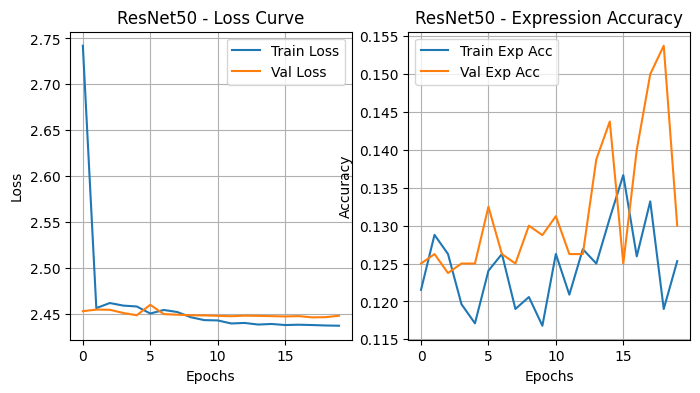

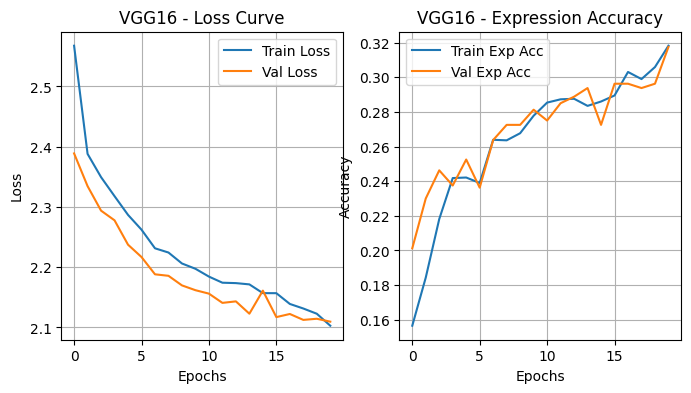

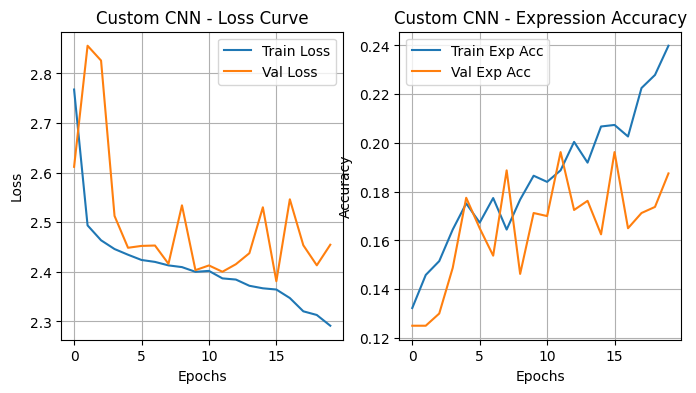

In [13]:
import matplotlib.pyplot as plt

def plot_training_curves(history, model_name):
    """Plots Training vs Validation Loss and Expression Accuracy"""
    plt.figure(figsize=(8,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    if "expression_output_accuracy" in history.history:
        plt.subplot(1,2,2)
        plt.plot(history.history['expression_output_accuracy'], label='Train Exp Acc')
        plt.plot(history.history['val_expression_output_accuracy'], label='Val Exp Acc')
        plt.title(f'{model_name} - Expression Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

    plt.show()


# Call for each model
plot_training_curves(history_resnet, "ResNet50")
plot_training_curves(history_vgg, "VGG16")
plot_training_curves(history_custom, "Custom CNN")


In [2]:
import numpy as np
import os
import cv2
import tensorflow as tf

IMG_HEIGHT, IMG_WIDTH = 224, 224
EXPRESSION_LABELS = {
    0: "Neutral", 1: "Happy", 2: "Sad", 3: "Surprise",
    4: "Fear", 5: "Disgust", 6: "Anger", 7: "Contempt"
}

sample_image_path = '/content/Dataset/Dataset/images/1099.jpg'

def preprocess_single_image(image_path, img_height, img_width):
    if not os.path.exists(image_path):
        return None
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

print(f"Processing image: {sample_image_path}")
preprocessed_img = preprocess_single_image(sample_image_path, IMG_HEIGHT, IMG_WIDTH)

if preprocessed_img is None:
    print("Image preprocessing failed.")
    exit()

print("\nAffect Recognition Results")

resnet_model = tf.keras.models.load_model("/content/resnet50_fer_va.h5", compile=False)
vgg_model = tf.keras.models.load_model("/content/vgg16_fer_va.h5", compile=False)
custom_model = tf.keras.models.load_model("/content/customcnn_fer_va.h5", compile=False)

def predict_and_display(model, name):
    preds = model.predict(preprocessed_img)

    if isinstance(preds, list) and len(preds) == 3:
        exp_probs, valence, arousal = preds
        exp_probs = exp_probs[0]
        valence = valence[0][0]
        arousal = arousal[0][0]

    else:
        exp_probs = preds[0]
        valence, arousal = None, None

    exp_label_idx = np.argmax(exp_probs)
    exp_label = EXPRESSION_LABELS[exp_label_idx]

    print(f"\n{name} Prediction")
    print(f"Expression: {exp_label} ({exp_probs[exp_label_idx]*100:.2f}%)")
    if valence is not None and arousal is not None:
        print(f"Valence: {valence:.2f}")
        print(f"Arousal: {arousal:.2f}")

predict_and_display(resnet_model, "ResNet50")
predict_and_display(vgg_model, "VGG16")
predict_and_display(custom_model, "Custom CNN")

Processing image: /content/Dataset/Dataset/images/1099.jpg

Affect Recognition Results
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step

ResNet50 Prediction
Expression: Happy (12.61%)
Valence: -0.19
Arousal: 0.35


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

VGG16 Prediction
Expression: Disgust (19.35%)
Valence: -0.32
Arousal: 0.22


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step

Custom CNN Prediction
Expression: Happy (20.07%)
Valence: -0.03
Arousal: 0.29
